RandomHorizontalFlip once again  
prev model: model_16

In [1]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms

from hack_utils import ScaleMinSideToSize, CropCenter, RandomHorizontalFlip, TransformByKeys
from hack_utils import ThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission
from hack_utils import stqdm
from hack_train import predict

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '../data/'
LOCAL_DATA_DIR = '/work/local_data/made_cv/contest1'

In [3]:
GPUs = [0, 1, 2]

In [4]:
NUM_PTS = 971
CROP_SIZE = 128
BATCH_SIZE = 256 * len(GPUs)
LR = 1e-3
NUM_WORKERS = 24
MODEL_NAME = 'model_17'

In [5]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    for batch in stqdm(loader, total=len(loader), desc="training...", leave=True):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(train_loss)

In [7]:
def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in stqdm(loader, total=len(loader), desc="validation...", leave=True):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)

In [8]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    RandomHorizontalFlip(0.5),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.4782, 0.3758, 0.3277], std=[0.3077, 0.2652, 0.2521]), ("image",)),
    TransformByKeys(transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3)), ("image",)),
])

In [9]:
test_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.4782, 0.3758, 0.3277], std=[0.3077, 0.2652, 0.2521]), ("image",)),
])

In [10]:
train_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), train_transforms, split="train")
val_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), test_transforms, split="val")

Total lines (without header): 393930
Loading train dataset (315144 lines)



Total lines (without header): 393930
Loading val dataset (78786 lines)


In [11]:
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                   shuffle=True, drop_last=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                 shuffle=False, drop_last=False)

In [12]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [13]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)

model = nn.DataParallel(model, device_ids=GPUs)

model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [14]:
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01, amsgrad=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1)
loss_fn = fnn.mse_loss

In [15]:
N_EPOCHS = 50
best_val_loss = np.inf
for epoch in stqdm(range(N_EPOCHS), total=N_EPOCHS, desc="Epoch"):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    lr_scheduler.step(val_loss)
    print("Epoch #{:2}:\ttrain loss: {:.5f}\tval loss: {:.5f}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)

Epoch # 0:	train loss: 201.07363	val loss: 21.17681


Epoch # 1:	train loss: 8.38306	val loss: 5.40766


Epoch # 2:	train loss: 5.07407	val loss: 4.26596


Epoch # 3:	train loss: 4.07444	val loss: 3.48575


Epoch # 4:	train loss: 3.65477	val loss: 3.29917


Epoch # 5:	train loss: 3.31693	val loss: 2.87296


Epoch # 6:	train loss: 3.07505	val loss: 2.68334


Epoch # 7:	train loss: 3.01337	val loss: 2.83938


Epoch # 8:	train loss: 2.90370	val loss: 2.68003


Epoch # 9:	train loss: 2.77189	val loss: 2.40668


Epoch #10:	train loss: 2.67246	val loss: 2.57213


Epoch #11:	train loss: 2.60930	val loss: 2.38890


Epoch #12:	train loss: 2.61545	val loss: 2.40665


Epoch #13:	train loss: 2.51853	val loss: 2.32964


Epoch #14:	train loss: 2.42066	val loss: 2.25802


Epoch #15:	train loss: 2.39298	val loss: 2.23225


Epoch #16:	train loss: 2.33665	val loss: 2.21828


Epoch #17:	train loss: 2.29724	val loss: 2.03856


Epoch #18:	train loss: 2.26542	val loss: 2.16778


Epoch #19:	train loss: 2.24652	val loss: 2.11603


Epoch #20:	train loss: 2.11508	val loss: 1.94762


Epoch #21:	train loss: 2.07399	val loss: 1.90822


Epoch #22:	train loss: 2.03542	val loss: 1.91341


Epoch #23:	train loss: 2.04373	val loss: 2.00357


Epoch #24:	train loss: 1.96038	val loss: 1.87623


Epoch #25:	train loss: 1.93635	val loss: 1.89413


Epoch #26:	train loss: 1.91874	val loss: 1.87238


Epoch #27:	train loss: 1.90406	val loss: 1.86898


Epoch #28:	train loss: 1.89467	val loss: 2.03131


Epoch #29:	train loss: 1.87846	val loss: 1.88168


Epoch #30:	train loss: 1.82263	val loss: 1.87490


Epoch #31:	train loss: 1.81143	val loss: 1.85812


Epoch #32:	train loss: 1.79282	val loss: 1.85334


Epoch #33:	train loss: 1.78328	val loss: 1.87076


Epoch #34:	train loss: 1.76686	val loss: 1.88678


Epoch #35:	train loss: 1.73559	val loss: 1.84971


Epoch #36:	train loss: 1.73416	val loss: 1.83073


Epoch #37:	train loss: 1.71884	val loss: 1.84214


Epoch #38:	train loss: 1.70847	val loss: 1.86758


Epoch #39:	train loss: 1.69654	val loss: 1.84559


Epoch #40:	train loss: 1.69055	val loss: 1.84921


Epoch #41:	train loss: 1.67863	val loss: 1.85550


Epoch #42:	train loss: 1.67822	val loss: 1.84454


Epoch #43:	train loss: 1.67529	val loss: 1.85021


Epoch #44:	train loss: 1.67309	val loss: 1.84180


Epoch #45:	train loss: 1.66836	val loss: 1.85106


Epoch #46:	train loss: 1.66694	val loss: 1.84640


Epoch #47:	train loss: 1.66562	val loss: 1.84979


Epoch #48:	train loss: 1.67145	val loss: 1.85057


Epoch #49:	train loss: 1.66629	val loss: 1.84922



In [16]:
f'Best validation loss: {best_val_loss}'

'Best validation loss: 1.8307337216960573'

In [17]:
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [18]:
test_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'test'), test_transforms, split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                  shuffle=False, drop_last=False)

Total lines (without header): 99819


In [19]:
test_predictions = predict(model, test_dataloader, device)
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl"), "wb") as fp:
    pickle.dump({"image_names": test_dataset.image_names,
                 "landmarks": test_predictions}, fp)

In [20]:
create_submission(DATA_DIR, test_predictions,
                 os.path.join(DATA_DIR, f"{MODEL_NAME}_submit_val_loss_{best_val_loss:.5f}.csv"))

In [21]:
TEST_PREDICTIONS_FILENAME = os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl")
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [22]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [23]:
with open(TEST_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

if len(image_names) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(image_names)}")

Images: 99819
Landmarks shape: (99819, 971, 2)


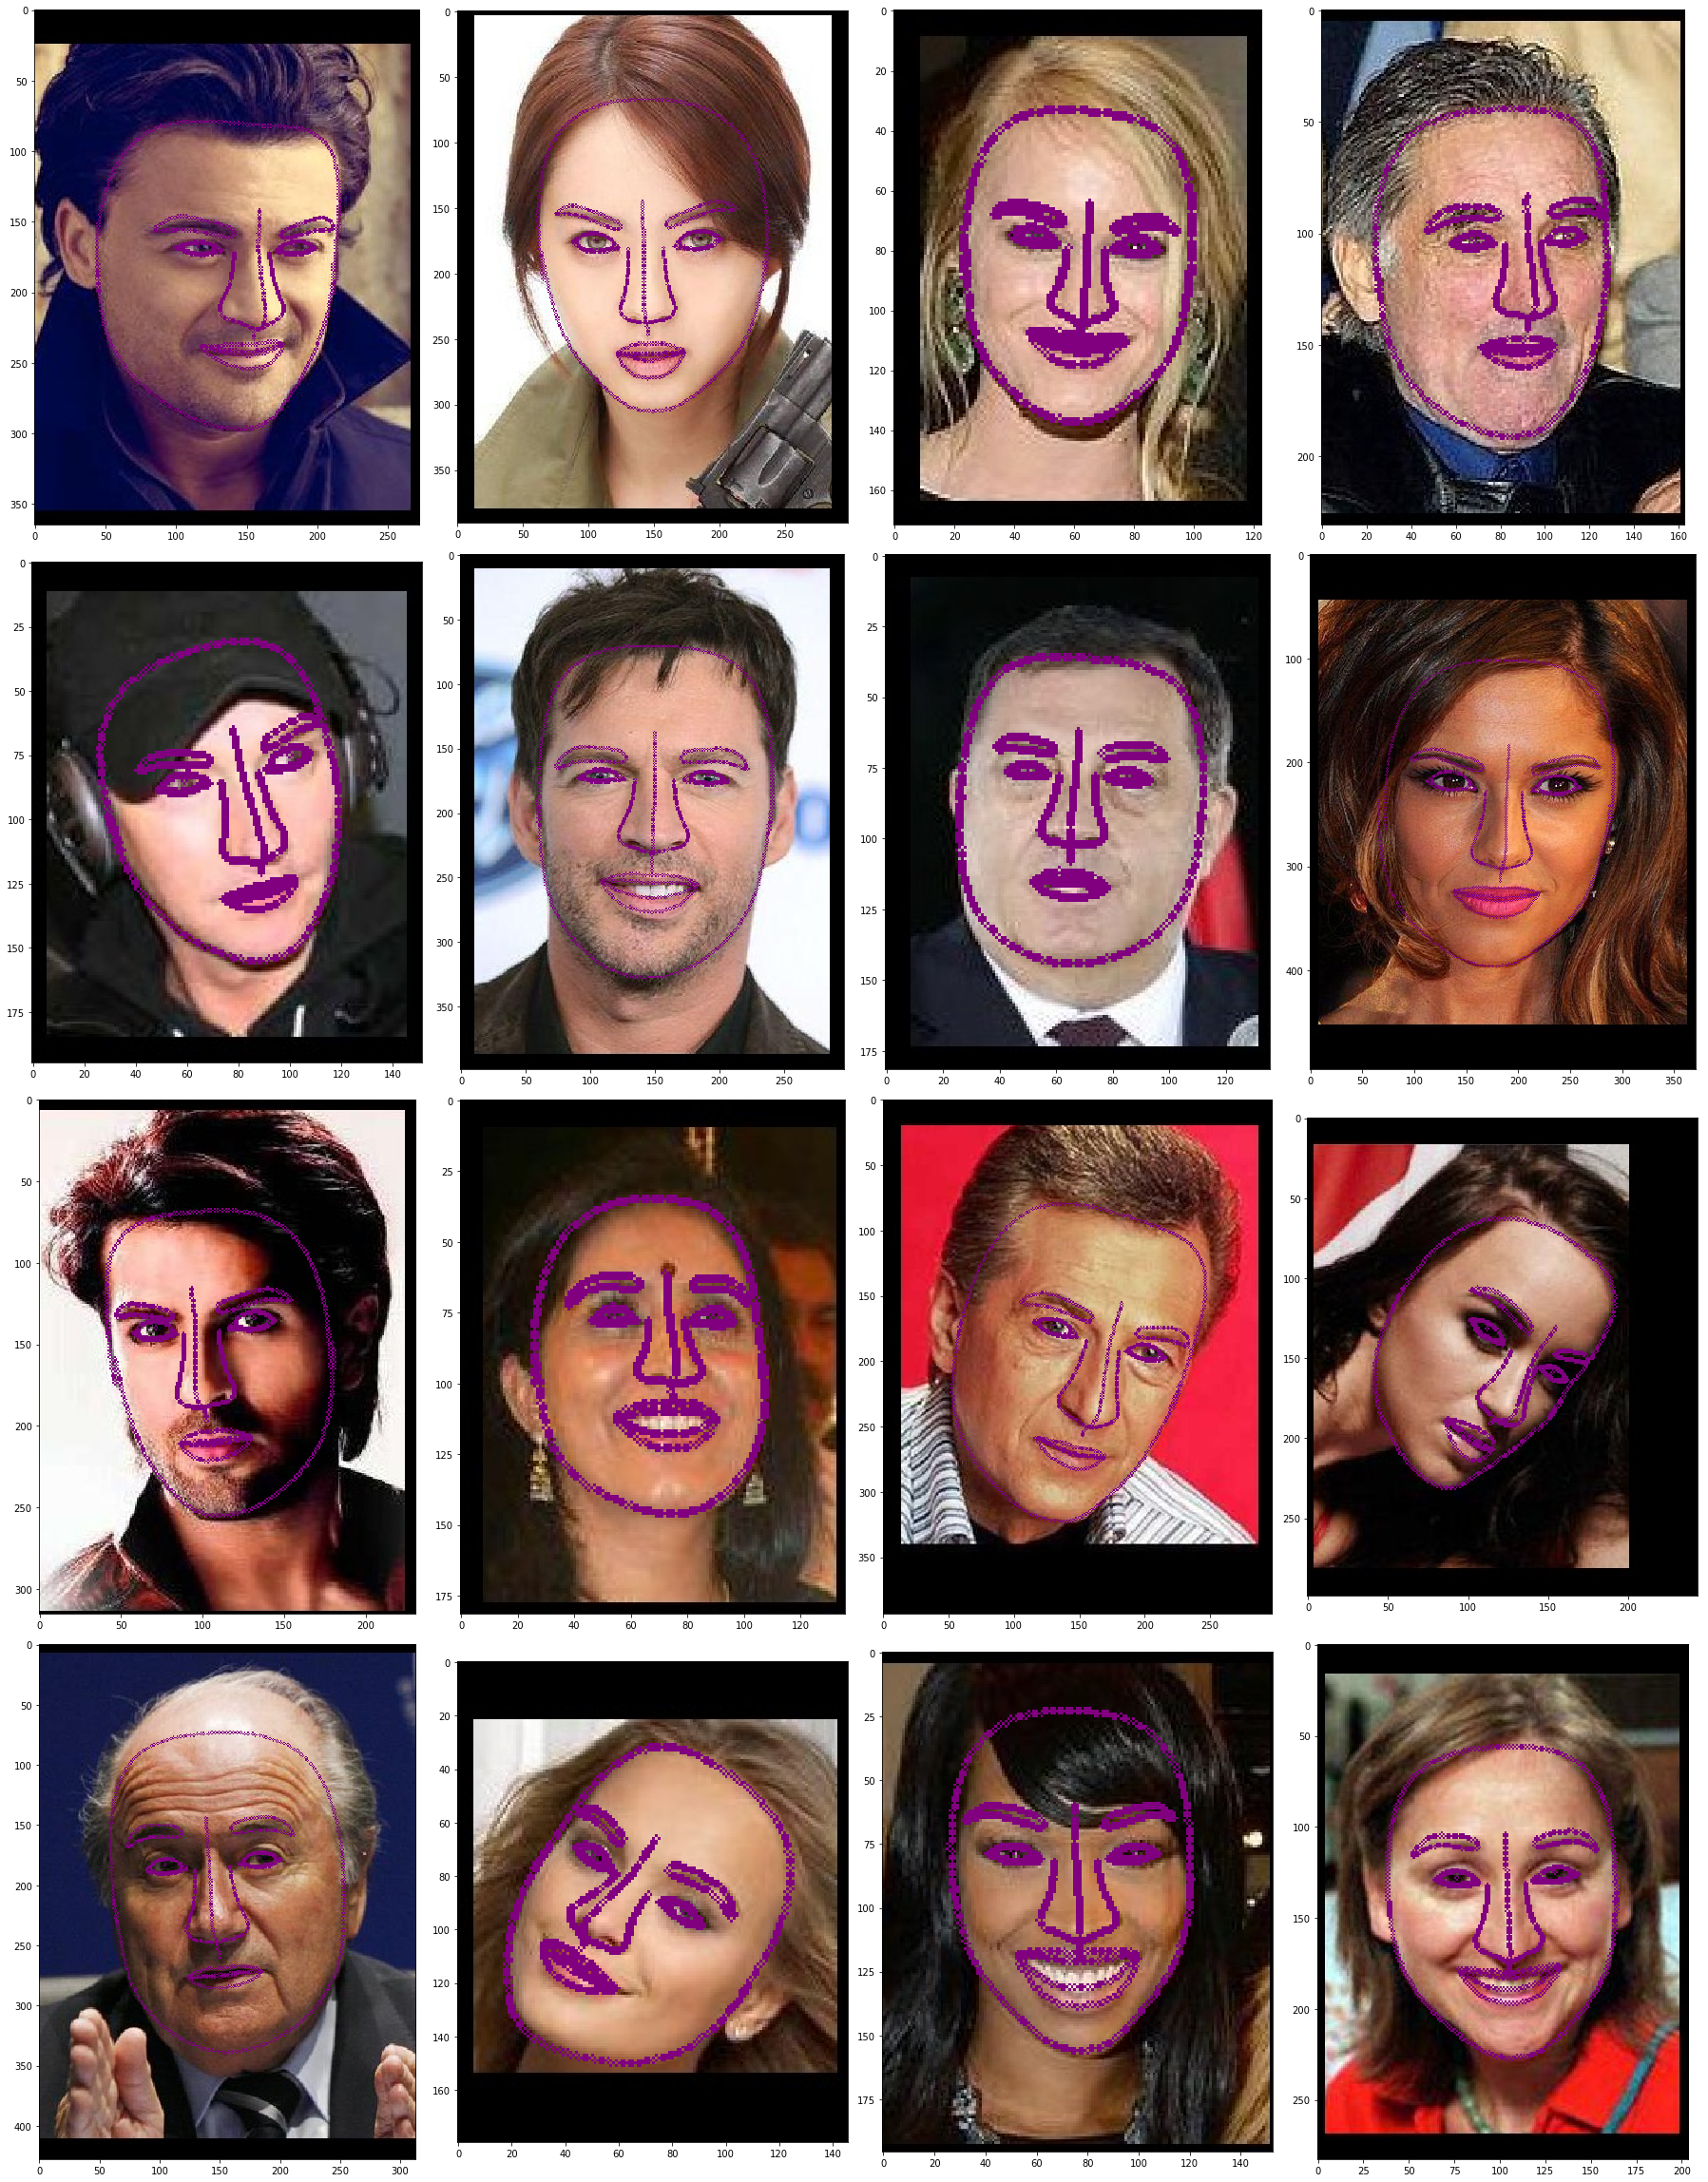

In [24]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()